[Epoch 1] Loss: 1.4430
[Epoch 2] Loss: 1.2385
[Epoch 3] Loss: 1.0918
[Epoch 4] Loss: 0.9972
[Epoch 5] Loss: 0.9373
[Epoch 6] Loss: 0.8978
[Epoch 7] Loss: 0.8744
[Epoch 8] Loss: 0.8452
[Epoch 9] Loss: 0.8319
[Epoch 10] Loss: 0.8166
[Epoch 11] Loss: 0.8000
[Epoch 12] Loss: 0.7915
[Epoch 13] Loss: 0.7836
[Epoch 14] Loss: 0.7735
[Epoch 15] Loss: 0.7659
[Epoch 16] Loss: 0.7585
[Epoch 17] Loss: 0.7509
[Epoch 18] Loss: 0.7433
[Epoch 19] Loss: 0.7386
[Epoch 20] Loss: 0.7360


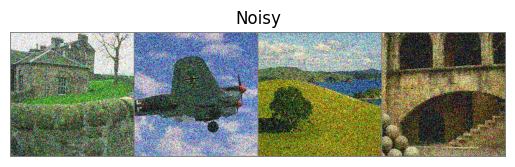

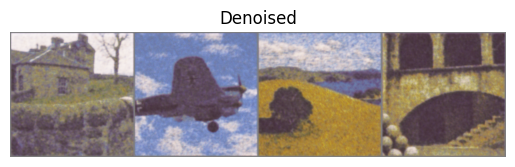

In [ ]:
import os, random, numpy as np, matplotlib.pyplot as plt
import torch, torch.nn as nn
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from collections import OrderedDict


class CustomImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])

    def __len__(self): return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform: image = self.transform(image)
        return image, self.image_files[idx]


class NoisyDataset(nn.Module):
    def __init__(self, mean=0, var=1):
        super().__init__()
        self.mean = mean
        self.var = var

    def forward(self, image):
        noise = torch.randn_like(image) * self.var + self.mean
        noisy_image = image + noise
        low_clip = -1. if image.min() < 0 else 0.
        return torch.clamp(noisy_image, min=low_clip, max=1.0)


# === U-Net ===
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, init_features=32):
        super().__init__()
        f = init_features
        self.encoder1 = self._block(in_channels, f, "enc1")
        self.pool1 = nn.MaxPool2d(2, 2)
        self.encoder2 = self._block(f, f*2, "enc2")
        self.pool2 = nn.MaxPool2d(2, 2)
        self.encoder3 = self._block(f*2, f*4, "enc3")
        self.pool3 = nn.MaxPool2d(2, 2)
        self.encoder4 = self._block(f*4, f*8, "enc4")
        self.pool4 = nn.MaxPool2d(2, 2)
        self.bottleneck = self._block(f*8, f*16, "bottleneck")
        self.upconv4 = nn.ConvTranspose2d(f*16, f*8, 2, 2)
        self.decoder4 = self._block(f*8*2, f*8, "dec4")
        self.upconv3 = nn.ConvTranspose2d(f*8, f*4, 2, 2)
        self.decoder3 = self._block(f*4*2, f*4, "dec3")
        self.upconv2 = nn.ConvTranspose2d(f*4, f*2, 2, 2)
        self.decoder2 = self._block(f*2*2, f*2, "dec2")
        self.upconv1 = nn.ConvTranspose2d(f*2, f, 2, 2)
        self.decoder1 = self._block(f*2, f, "dec1")
        self.conv = nn.Conv2d(f, out_channels, 1)

    def forward(self, x):
        enc1 = self.encoder1(x); enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2)); enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))
        dec4 = self.decoder4(torch.cat((self.upconv4(bottleneck), enc4), 1))
        dec3 = self.decoder3(torch.cat((self.upconv3(dec4), enc3), 1))
        dec2 = self.decoder2(torch.cat((self.upconv2(dec3), enc2), 1))
        dec1 = self.decoder1(torch.cat((self.upconv1(dec2), enc1), 1))
        return 2 * torch.sigmoid(self.conv(dec1)) - 1

    def _block(self, in_c, out_c, name, ks=3, pad=1):
        return nn.Sequential(OrderedDict([
            (name + "conv1", nn.Conv2d(in_c, out_c, ks, padding=pad, bias=False)),
            (name + "norm1", nn.BatchNorm2d(out_c)),
            (name + "relu1", nn.ReLU(inplace=True)),
            (name + "conv2", nn.Conv2d(out_c, out_c, ks, padding=pad, bias=False)),
            (name + "norm2", nn.BatchNorm2d(out_c)),
            (name + "relu2", nn.ReLU(inplace=True)),
        ]))


class RegularizedLoss(nn.Module):
    def __init__(self, gamma=2): super().__init__(); self.gamma = gamma
    def mseloss(self, x, y): return torch.mean((x - y) ** 2)
    def regloss(self, g1, g2, G1, G2): return torch.mean((g1 - g2 - G1 + G2) ** 2)
    def forward(self, fg1, g2, G1f, G2f): return self.mseloss(fg1, g2) + self.gamma * self.regloss(fg1, g2, G1f, G2f)


def subsample(image, k=2, use_cuda=False):
    blen, channels, m, n = image.shape
    dim1, dim2 = m // k, n // k
    image1 = torch.zeros((blen, channels, dim1, dim2))
    image2 = torch.zeros((blen, channels, dim1, dim2))

    if use_cuda:
        image1, image2 = image1.cuda(), image2.cuda()

    for c in range(channels):
        for i in range(dim1):
            for j in range(dim2):
                i1, j1 = i * k, j * k
                r = np.random.choice([0, 1, 2, 3])
                offsets = [(0, 0), (1, 1), (1, 0), (0, 1)]
                dx1, dy1 = offsets[r]
                dx2, dy2 = offsets[(r + 1) % 4]
                image1[:, c, i, j] = image[:, c, i1 + dx1, j1 + dy1]
                image2[:, c, i, j] = image[:, c, i1 + dx2, j1 + dy2]

    return image1, image2



def imshow(img, title=''):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title: plt.title(title)
    plt.axis('off')
    plt.show()


EPOCHS, BATCH, VAR, LR = 20, 4, 0.5, 0.0005
DATA_DIR = './data'
transform = transforms.Compose([
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
use_cuda = torch.cuda.is_available()


trainloader = DataLoader(CustomImageDataset(f'{DATA_DIR}/train', transform), batch_size=BATCH, shuffle=True)
validloader = DataLoader(CustomImageDataset(f'{DATA_DIR}/val', transform), batch_size=BATCH, shuffle=True)
testset = CustomImageDataset(f'{DATA_DIR}/test', transform)
testloader = DataLoader(testset, batch_size=4)


model = UNet().float()
if use_cuda: model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = RegularizedLoss(gamma=2)
noisy = NoisyDataset(var=VAR)


for epoch in range(EPOCHS):
    model.train()
    for batch, _ in trainloader:
        noisy_image = noisy(batch).clone().detach().float()
        if use_cuda: noisy_image = noisy_image.cuda()
        g1, g2 = subsample(noisy_image, use_cuda=use_cuda)
        fg1 = model(g1)
        with torch.no_grad():
            X = model(noisy_image)
            G1, G2 = subsample(X, use_cuda=use_cuda)
        loss = criterion(fg1, g2, G1, G2)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    print(f"[Epoch {epoch+1}] Loss: {loss.item():.4f}")


model.eval()
images, _ = next(iter(testloader))
noisy_images = noisy(images).clone().detach().float()
if use_cuda: noisy_images = noisy_images.cuda()
denoised = model(noisy_images)
imshow(utils.make_grid(noisy_images.cpu()), title="Noisy")
imshow(utils.make_grid(denoised.detach().cpu()), title="Denoised")


In [ ]:
!unzip data.zip

Archive:  data.zip
   creating: data/
   creating: data/test/
  inflating: data/test/0.jpg         
  inflating: data/test/1.jpg         
  inflating: data/test/2.jpg         
  inflating: data/test/3.png         
   creating: data/train/
  inflating: data/train/0.jpg        
  inflating: data/train/1.jpg        
  inflating: data/train/2.jpg        
  inflating: data/train/3.png        
   creating: data/val/
  inflating: data/val/0.jpg          
  inflating: data/val/1.jpg          
  inflating: data/val/2.jpg          
  inflating: data/val/3.png          


Epoch 1/30, Loss: 0.0235
Epoch 2/30, Loss: 0.0126
Epoch 3/30, Loss: 0.0093
Epoch 4/30, Loss: 0.0081
Epoch 5/30, Loss: 0.0074
Epoch 6/30, Loss: 0.0060
Epoch 7/30, Loss: 0.0061
Epoch 8/30, Loss: 0.0065
Epoch 9/30, Loss: 0.0061
Epoch 10/30, Loss: 0.0063
Epoch 11/30, Loss: 0.0050
Epoch 12/30, Loss: 0.0055
Epoch 13/30, Loss: 0.0051
Epoch 14/30, Loss: 0.0046
Epoch 15/30, Loss: 0.0046
Epoch 16/30, Loss: 0.0051
Epoch 17/30, Loss: 0.0066
Epoch 18/30, Loss: 0.0049
Epoch 19/30, Loss: 0.0055
Epoch 20/30, Loss: 0.0051
Epoch 21/30, Loss: 0.0061
Epoch 22/30, Loss: 0.0063
Epoch 23/30, Loss: 0.0046
Epoch 24/30, Loss: 0.0051
Epoch 25/30, Loss: 0.0055
Epoch 26/30, Loss: 0.0058
Epoch 27/30, Loss: 0.0062
Epoch 28/30, Loss: 0.0062
Epoch 29/30, Loss: 0.0065
Epoch 30/30, Loss: 0.0052


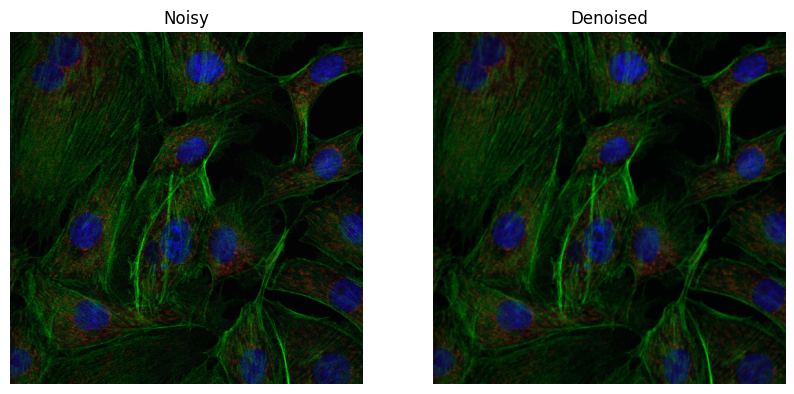

In [ ]:
import os
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch import optim


class UNet(nn.Module):
    def __init__(self, in_nc=3, out_nc=3, n_feature=48):
        super(UNet, self).__init__()
        def CBR(in_ch, out_ch): return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.ReLU(inplace=True)
        )
        self.enc1 = nn.Sequential(CBR(in_nc, n_feature), CBR(n_feature, n_feature))
        self.enc2 = nn.Sequential(CBR(n_feature, n_feature), CBR(n_feature, n_feature))
        self.enc3 = nn.Sequential(CBR(n_feature, n_feature), CBR(n_feature, n_feature))
        self.enc4 = nn.Sequential(CBR(n_feature, n_feature), CBR(n_feature, n_feature))

        self.pool = nn.MaxPool2d(2)
        self.up = lambda x: nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        self.dec3 = CBR(n_feature * 2, n_feature)
        self.dec2 = CBR(n_feature * 2, n_feature)
        self.dec1 = CBR(n_feature * 2, n_feature)
        self.out = nn.Conv2d(n_feature, out_nc, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        d3 = self.dec3(torch.cat([self.up(e4), e3], 1))
        d2 = self.dec2(torch.cat([self.up(d3), e2], 1))
        d1 = self.dec1(torch.cat([self.up(d2), e1], 1))
        return self.out(d1)


class PatchDataset(Dataset):
    def __init__(self, image, size):
        self.data = []
        c, h, w = image.shape
        for i in range(0, h-size+1, size):
            for j in range(0, w-size+1, size):
                self.data.append(image[:, i:i+size, j:j+size])
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]


def neighbor_subsample(img):
    if img.ndim == 5:
        img = img.squeeze(1)
    b, c, h, w = img.shape
    patches = img.unfold(2, 2, 2).unfold(3, 2, 2).contiguous().view(b, c, h//2, w//2, 4)
    i1, i2 = torch.randint(0, 4, (2,), device=img.device).tolist()
    return patches[..., i1], patches[..., i2]


image_path = "rgb4_noise.png"
img = Image.open(image_path).convert("RGB")
npimg = np.array(img).astype(np.float32) / 255.0
tensor_img = transforms.ToTensor()(npimg).unsqueeze(0).cuda()


model = UNet().cuda()
opt = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()
dataset = PatchDataset(tensor_img.squeeze(0), 64)
loader = DataLoader(dataset, batch_size=8, shuffle=True)
epochs = 30

for e in range(epochs):
    total_loss = 0
    for batch in loader:
        batch = batch.cuda()
        sub1, sub2 = neighbor_subsample(batch)
        out = model(sub1)
        with torch.no_grad():
            den = model(batch)
        dsub1, dsub2 = neighbor_subsample(den)
        loss = loss_fn(out, sub2) + 2.0 * loss_fn(out - sub2, dsub1 - dsub2)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {e+1}/{epochs}, Loss: {total_loss/len(loader):.4f}")

model.eval()
with torch.no_grad():
    out = model(tensor_img).clamp(0, 1).squeeze().permute(1, 2, 0).cpu().numpy()
    out_img = (out * 255).astype(np.uint8)
    in_img = (npimg * 255).astype(np.uint8)
    Image.fromarray(in_img).save("noisy_saved.png")
    Image.fromarray(out_img).save("denoised_saved.png")


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1); plt.imshow(in_img); plt.title("Noisy"); plt.axis("off")
plt.subplot(1, 2, 2); plt.imshow(out_img); plt.title("Denoised"); plt.axis("off")
plt.show()
